# Import Libraries

In [1]:
!pip install contractions
!pip install --upgrade keras-nlp
!pip install --upgrade keras
#!pip install --upgrade tensorflow
!pip install tensorflow==2.8.0
!pip install transformers==4.18.0
!pip install keras_tuner


  Using cached tensorflow-2.8.0-cp310-cp310-manylinux2010_x86_64.whl (497.6 MB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ER

In [2]:
import sys
import os

# Print Python version
print("Python version:")
print(sys.version)
print()

# Function to get the name of the virtual environment
def get_environment_name():
    venv = os.getenv('VIRTUAL_ENV')
    if venv:
        return os.path.basename(venv)
    else:
        return "No virtual environment detected"

# Print environment name
print("Environment name:")
print(get_environment_name())


Python version:
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

Environment name:
No virtual environment detected


In [3]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
import re

# 3D plotting
from mpl_toolkits.mplot3d import Axes3D

# Scikit-learn
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import keras_tuner as kt

# Transformers and Keras NLP
from transformers import BertTokenizer, TFBertModel
import keras_nlp
import keras.backend as K

# NLTK
import nltk
from nltk.tokenize import word_tokenize
import contractions

# WordCloud
from wordcloud import WordCloud

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Initialize the inflect engine
import inflect
p = inflect.engine()

# Constants
MAX_FEATURES = 768
NUM_CLUSTERS = 5
NUM_CLASSES = 6
EPOCHS = 100
BATCH_SIZE = 32
SEED = 0

# Set colormap
cmap = mpl.cm.get_cmap('viridis')

# Ensure reproducibility
np.random.seed(SEED)


Using TensorFlow backend


<ipython-input-3-e3132f75822f>:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis')


This code is setting an environment variable KERAS_BACKEND to either "jax", "tensorflow", or "torch". This variable specifies the backend engine that Keras, a high-level neural networks API, will use for computation.

By setting it to "jax", it indicates that Keras should use the JAX (Just Another eXperimental) backend for computation. JAX is a numerical computing library developed by Google, known for its automatic differentiation and ability to accelerate numerical code on CPUs, GPUs, and TPUs.

Alternatively, setting it to "tensorflow" indicates the use of TensorFlow as the backend, while setting it to "torch" indicates the use of PyTorch as the backend. These are other popular deep learning frameworks that can be used with Keras as the frontend API for building and training neural networks.

# Import Data/EDA

In [4]:
!pwd

/content


In [7]:
essay_df = pd.read_csv('sample_data/train.csv')

# just the first 2000 rows from the data: Proof of concept testing
essay_df = essay_df.iloc[:6000]

essay_df.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


examine the data in Numbers to get a sense of the punctuation or text traits that may need to be addressed in preprocessing.

# Preproccessing

In [8]:
def contains_numeric(token):
  return any(char.isdigit() for char in token)


def convert_numbers_to_words(token):
  if contains_numeric(token):
    # Remove any punctuation from the token before conversion
    # Keeps alphanumeric, whitespace, and "."s, remove anything else
    token = re.sub(r'[^\w\s.]', '', token)

    wordString = p.number_to_words(token)

    wordString = wordString.replace("-", " ")

    # Tokenize the wordString
    tokens = word_tokenize(wordString)

    return tokens # Return the flat list of tokens instead of a list of lists
  else:
    return [token] # Return the token as a list

# Takes in a raw essay - just a long string
# Outputs a cleaned up list of tokens

def preprocess(rawEssay):
  # Step 1: replace hypens with spaces
  rawEssay = rawEssay.replace("-", " ")

  # Step 2: replace % with the word percent
  rawEssay = rawEssay.replace("%", "percent")

  # Put any other future single character manipulations here

  # Step 3: expand contractions ex: I'm -> I am
  essayExpanded = contractions.fix(rawEssay)

  # Step 4: take the big long string and turn it into tokens (individual strings)
  tokens = word_tokenize(essayExpanded) # just splitting on spaces

  # Step 5: convert the numberic tokens to one or more word tokens
  # ex: 10% -> ['ten', 'percent'] or 1.00 -> ['one', 'point', 'zero', 'zero']
  # use a new array to preserve the order of the tokens
  processedTokens = []

  # leaves non-numeric tokens alone
  for token in tokens:
    processedTokens.extend(convert_numbers_to_words(token))

  # Step 6: remove non-alphabet tokens and lowercase everything
  essayTokens = [word.lower() for word in processedTokens if word.isalpha()]

  # Step 7: remove stop words (common words like 'the', 'and', etc.)
  stop_words = set(nltk.corpus.stopwords.words('english'))
  additional_stop_words = {'would', 'could', 'should'}
  stop_words.update(additional_stop_words)

  essayTokensClean = [word for word in essayTokens if word not in stop_words]

  return essayTokensClean

Visualilze the dataset score distribution.

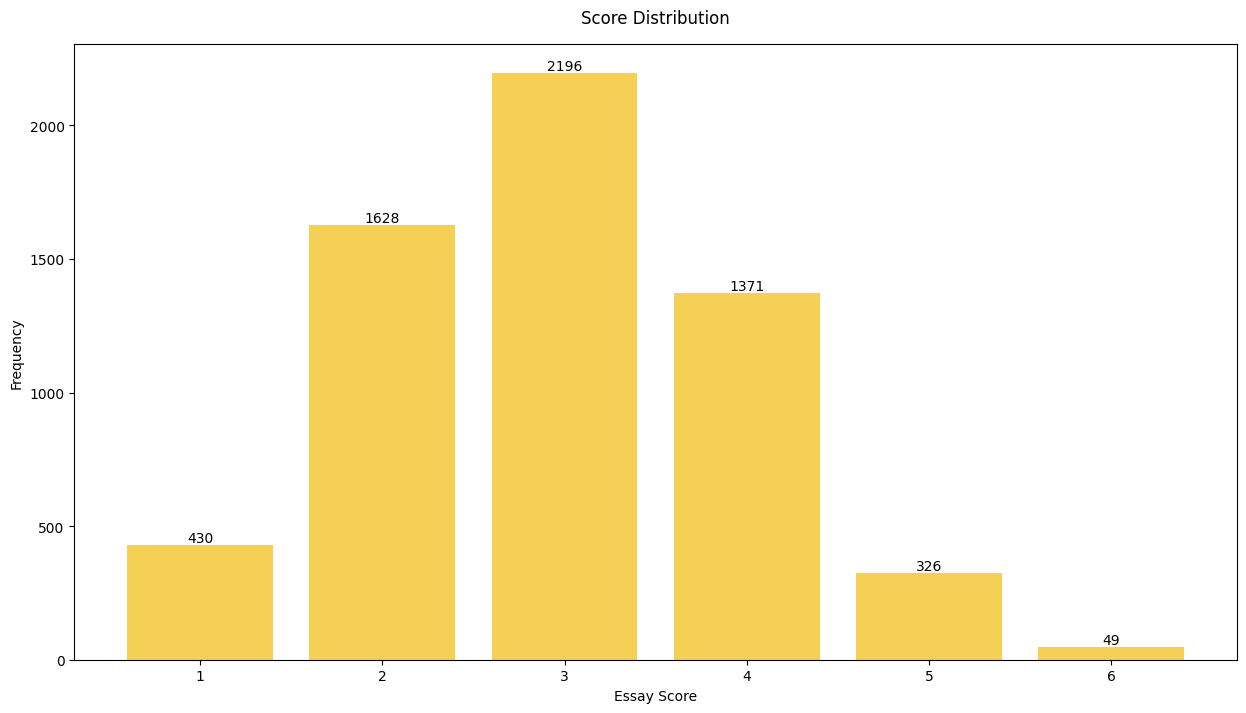

In [45]:
def essay_score_dist(essay_df):
    '''
    Creates a bar plot of score counts for each essay based on the 'score' column.

    Input:
    df : Pandas dataframe containing information about essays with a 'score' column

    Output:
    None (Displays a matplotlib figure)
    '''
    # Create a Counter of scores from the available data
    score_bins = Counter(essay_df['score'])

    # Define all bins to display
    all_bins = [1, 2, 3, 4, 5, 6]

    # Create counts for all bins, filling missing bins with zero counts
    counts_per_bin = {bins: score_bins.get(bins, 0) for bins in all_bins}

    # Plot the count of different scores
    plt.figure(figsize=(15, 8))
    bars = plt.bar(counts_per_bin.keys(), counts_per_bin.values(), color='#F4D054')

    plt.ylabel('Frequency')
    plt.xlabel('Essay Score')
    plt.title('Score Distribution', y=1.02)

    # Show the counts on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

    plt.show()

# View dataframe
essay_score_dist(essay_df)


In [10]:
# Tokenize the essays
essay_df['preprocessed'] = essay_df['full_text'].apply(preprocess)
essay_df['preprocessed_str'] = essay_df['preprocessed'].apply(lambda x: ' '.join(x))

# Normalize scores
def min_max_normalization(score):
    return (score - 1) / (6-1)

essay_df['normalized_score'] = essay_df.apply(lambda row: min_max_normalization(row['score']), axis=1)

essay_df

,essay_id,full_text,score,preprocessed,preprocessed_str,normalized_score
0,000d118,Many people have car where they live. The thin...,3,"[many, people, car, live, thing, know, use, ca...",many people car live thing know use car alot t...,0.4
1,000fe60,I am a scientist at NASA that is discussing th...,3,"[scientist, nasa, discussing, face, mars, expl...",scientist nasa discussing face mars explaining...,0.4
2,001ab80,People always wish they had the same technolog...,4,"[people, always, wish, technology, seen, movie...",people always wish technology seen movies best...,0.6
3,001bdc0,"We all heard about Venus, the planet without a...",4,"[heard, venus, planet, without, almost, oxygen...",heard venus planet without almost oxygen earth...,0.6
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,"[dear, state, senator, letter, argue, favor, k...",dear state senator letter argue favor keeping ...,0.4
...,...,...,...,...,...,...
5995,59dcb0c,Technology to read the emotional expressions o...,2,"[technology, read, emotional, expressions, stu...",technology read emotional expressions students...,0.2
5996,59e32c9,"In the article ""The Challenge of Exploring ven...",2,"[article, challenge, exploring, venus, author,...",article challenge exploring venus author sugge...,0.2
5997,59e3ebc,My position on the driverless cars are definit...,4,"[position, driverless, cars, definitley, whole...",position driverless cars definitley whole idea...,0.6
5998,59e5c22,"Ford, Volkswagen, Kia, and Chevy's... while th...",4,"[ford, volkswagen, kia, chevy, car, brands, ma...",ford volkswagen kia chevy car brands may massi...,0.6


Basic TF-IDF and neural net. This represents the simplest, straightforward, base-model possible using default parameters.

In [12]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=768)  # Adjust max_features as needed

# Fit and transform the text data
X = tfidf_vectorizer.fit_transform(essay_df['preprocessed_str']).toarray()

In [13]:
# Set the seed for reproducibility
np.random.seed(42)

# Generate 5 random indices
random_indices = np.random.choice(essay_df.index, size=5, replace=False)

# Print the full text and preprocessed text for each random row
for index in random_indices:
  print("Row Index:", index)
  print("Full Text:")
  print(essay_df.loc[index, 'full_text'])
  print("\nPreprocessed Text:")
  print(essay_df.loc[index, 'preprocessed'])
  print("\n" + "="*50 + "\n") # add a separator between rows

Row Index: 1782
Full Text:
Car alarms, car horns, and engines are basically the only thing people hear nowadays. The number of cars in the streets are simply begining to get out of hand.

Citizens all around the world, we all should really try to limit the amount of time that we are spending using our vehicals.

If you really take a moment to think about it, this could honestly turn out to be a really good thing.

Cars are not neccisarily a need, they are a want. I can undertand if you are going to be traveling a far distance that two feet cant get you, but certianlty and ten minute walk to the grocery store/market cant hurt.

Limiting car usage is very important. Most families tend to spend about about $20-50.00 on gas a week. One advantage to limiting car usuage is saving a ton of money on gas that could easily be spent of food, to feed your family.

" "

When I had a car I was always tense. I'm much happier this way" " People who have decided to limit the amount of time they spent u

This is a check with the preprocessed and the full text next to each other to be sure that the preprocessing worked the way that it was suppoed to - the preprocessed text is a list of strings; exactly what we expect.

In [14]:
# Prepare target labels
#X = np.stack(essay_df['bert_embeddings'].values)
y = essay_df['score'].values
from tensorflow.keras.utils import to_categorical

# One-hot encode the target labels
# The probability predictions need a map to the essay grade/score otherwise the
#neuralnet output is undetermined and doesn't make sense.

# categorical data (score/grade)
# Step 1: Convert grade to integer labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)

# Step 2: Reshape the data to be a 2D array as required by OneHotEncoder
integer_encoded = integer_encoded.reshape(-1, 1)

# Step 3: Apply OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_one_hot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Print the results
print("Original Categories:", y)
print("Integer Encoded:", integer_encoded.ravel())
print("One-Hot Encoded:\n", y_one_hot_encoded)
#.unique

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot_encoded, test_size=0.2, random_state=42)

Original Categories: [3 3 4 ... 4 4 4]
Integer Encoded: [2 2 3 ... 3 3 3]
One-Hot Encoded:
 [[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
# Build and compile model
input_dim = X_train.shape[1] #number of features
#dimensionality of the vectors is specified [1] chooses which feature in the set

#multiclass
#Number of classes
num_classes = y_one_hot_encoded.shape[1] #number of classes


# Build and compile a simple Keras model for multiclass classification
#like specificying how each split decision is made in a decision tree
inputs = Input(shape=(input_dim,)) #input layer; shape 768 dimensions; setting up an empty framework
x = Dense(128, activation='relu')(inputs) # x=hidden layer; each input gets an additional hidden layer added to the previous group
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # Softmax activation for multiclass classification


model = Model(inputs=inputs, outputs=outputs)

#multiclass
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 107,078
Trainable params: 107,078
Non-trainable

# Model Training


In [16]:
# step 4: Build and Train the Neural Network
# Train the model
# Train the Keras model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, validation_split=0.2)

#multiclass

# Predictions on training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print (y_train_pred)
print (y_test_pred)

#predictions are probabilities of which class (grade) the essay will be placed in


Epoch 1/50
120/120 [==============================] - 2s 8ms/step - loss: 1.5396 - accuracy: 0.3396 - val_loss: 1.4066 - val_accuracy: 0.3771
Epoch 2/50
120/120 [==============================] - 1s 6ms/step - loss: 1.4294 - accuracy: 0.3682 - val_loss: 1.3653 - val_accuracy: 0.3698
Epoch 3/50
120/120 [==============================] - 1s 6ms/step - loss: 1.3585 - accuracy: 0.3987 - val_loss: 1.2903 - val_accuracy: 0.4208
Epoch 4/50
120/120 [==============================] - 1s 6ms/step - loss: 1.2760 - accuracy: 0.4411 - val_loss: 1.2470 - val_accuracy: 0.4333
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 1.2065 - accuracy: 0.4888 - val_loss: 1.2179 - val_accuracy: 0.4281
Epoch 6/50
120/120 [==============================] - 0s 4ms/step - loss: 1.1414 - accuracy: 0.5174 - val_loss: 1.2045 - val_accuracy: 0.4500
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 1.0904 - accuracy: 0.5437 - val_loss: 1.1985 - val_accuracy: 0.4677
Epoch 

In [17]:
# Convert probabilities to class predictions
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

print(y_train_pred_classes)
print(y_test_pred_classes)
print(y)
print(y_one_hot_encoded)

[2 2 1 ... 2 2 1]
[2 3 0 ... 3 0 1]
[3 3 4 ... 4 4 4]
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [18]:
# Convert integer labels to original categories
predicted_categories_train = label_encoder.inverse_transform(y_train_pred_classes)
predicted_categories_test = label_encoder.inverse_transform(y_test_pred_classes)
print(predicted_categories_train)
print(predicted_categories_test)

[3 3 2 ... 3 3 2]
[3 4 1 ... 4 1 2]


Doesn't look like the model made any 6 predictions

These are great baseline accuracy scores to compare to other more advanced models.





In [19]:
# Calculate accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(np.argmax(y_train, axis=1), y_train_pred_classes)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred_classes)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Train Accuracy: 0.890625
Test Accuracy: 0.4066666666666667


# Final Evaluation

38/38 [==============================] - 0s 2ms/step - loss: 2.9283 - accuracy: 0.4067
Test Loss: 2.928327798843384
Test Accuracy: 0.40666666626930237


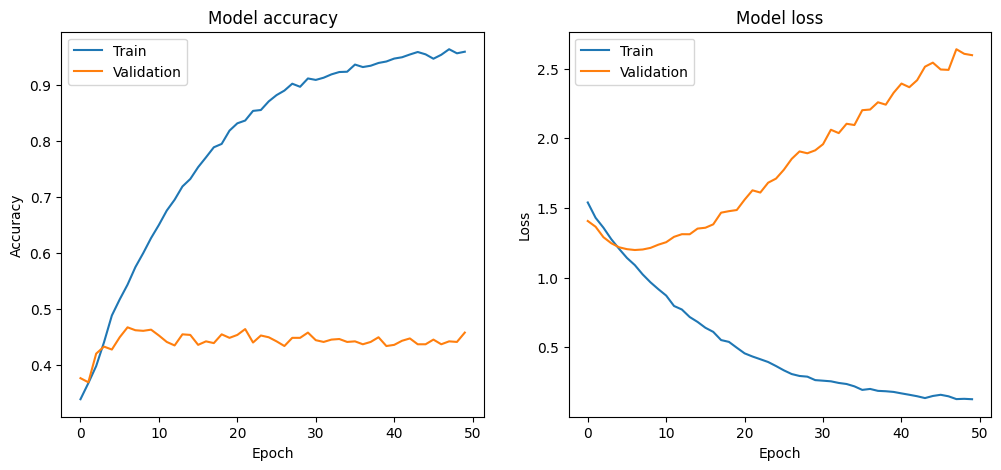

In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot the training and validation accuracy/loss over epochs
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Data is not consistent (accuracy is not high, orange; loss orange is perfect with a minimum on the curve) to investigate add more layers and nodes and see if the orange gets better.

more loss is bad so because the orange loss increases over the epochs, it stays steady on the accuracy (not improving).

This shows overfitting, but there's a promising  model to extract because there is a part of the loss curve that has a negative slope. How could we extend this part of the curve?

The essays were originally graded by many humans leading to subjective intrepretation of the grading rubric.